#AI-QSAR model for PKPD relationship development between NP and tumor cell

##Author:Kun Mi
##Advisor: Zhoumeng Lin

##Date created: 2025/07/16
##Date for last revision: 2025/11/14


# Install and import required python pacakges

In [1]:
# Install python pacakges
!pip install -q scikit-optimize # install the package used for Bayesian optimization
# !pip install -q scikeras[tensorflow]
!pip install -q tensorflow
!pip install -q keras-tuner
!pip install -q iterative-stratification
!pip install -q seaborn
!pip install -q optuna
!pip install -q scikeras
!pip install -q catboost
!pip install -q optuna-integration[tfkeras]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 7.0 MB/s eta 0:00:00


In [2]:
#Install basic python pcakges
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_log_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from time import time

# Link to google drive and set up your project folder

In [3]:
#Mount drive to google colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Set your working directory to a speicifc folder in your Google Drive
# The base Google Drive directory
root_dir = "/content/drive/My Drive/Colab Notebooks"

# choose where you want your project files to be saved
project_folder = "/NanoPKPD/" # Name your project here. Please instead the "my project folder" to your prefer name

# Make sure that floder exists. If not, automatically create a new folder
if (not os.path.isdir(root_dir + project_folder)):
  os.mkdir(root_dir + project_folder)
  print(root_dir + project_folder + 'did not exist but was created.')

# Change the OS to use your project folder as the working directory
os.chdir(root_dir + project_folder)

Mounted at /content/drive


# Data exploration

In [4]:
# importer Data
Data = pd.read_csv(os.path.join(root_dir + project_folder + "df_ML.csv"))

# Visual check of data

In [5]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539 entries, 0 to 538
Data columns (total 56 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      539 non-null    int64  
 1   Type                    539 non-null    object 
 2   Inorganic.Material      125 non-null    object 
 3   Organic.Material        389 non-null    object 
 4   MAT                     539 non-null    object 
 5   Targeting               539 non-null    object 
 6   NM.ID                   539 non-null    object 
 7   Shape                   539 non-null    object 
 8   Charge                  539 non-null    object 
 9   PDI                     343 non-null    object 
 10  NM.TEM.Size..nm.        61 non-null     float64
 11  Size                    539 non-null    float64
 12  Zeta                    539 non-null    float64
 13  Tumor_model             539 non-null    object 
 14  Cancer_type             539 non-null    ob

##Data mining

In [ ]:
df_data=pd.DataFrame(Data)

# Define the used features
df=df_data[[
    "ID",
    "Type",
    "MAT",
    "Targeting",
    "Shape",
    "Size",
    "Zeta",
    "Tumor_model",
    "Cancer_type",
    "Admin_frequency",
    "Route",
    'Time',
    'TGI.',
    "TGI_cat",
    "Multi_class",
    "Codelivery",
    "Dose_1_total",
    "Dose_2_total",
    "Techen",
    "PT",
    "PATC",
    "KTRESrelease",
    "KTRESn",
    "KTRESmax",
    "KTRES50",
    "AUCTumor",
    "DE24",
    "DE168",
    "DEmax"]]

# Data preprocessing

In [ ]:
# see how many missing values in your dataset
df.isna().sum()

,0
ID,0
Type,0
MAT,0
Targeting,0
Shape,0
Size,0
Zeta,0
Tumor_model,0
Cancer_type,0
Admin_frequency,0


In [ ]:
# prompt: exclude the dataset if therapy type is not single
df = df[df['Codelivery'].isin(['Single', 'Combination'])]
df = df[df['Route'] == 'iv']
df

,ID,Type,MAT,Targeting,Shape,Size,Zeta,Tumor_model,Cancer_type,Admin_frequency,...,PT,PATC,KTRESrelease,KTRESn,KTRESmax,KTRES50,AUCTumor,DE24,DE168,DEmax
0,1,Organic,Liposome,Active,Spherical,180.8,15.0,AO,Lung,Multiple,...,0.077564,0.044385,0.578647,0.041675,0.754870,19.074432,2813.925620,1.922250,0.046687,2.360682
1,2,Organic,Liposome,Passive,Spherical,150.2,26.3,AO,Lung,Multiple,...,0.178706,0.041310,0.030631,0.885903,1.396047,18.400389,141635.744500,22.146282,10.756988,43.403973
4,12,Organic,Polymeric,Passive,Spherical,83.2,-6.3,XH,Prostate,Multiple,...,0.135538,0.009932,0.454699,2.682884,0.850904,56.031796,1668.669582,2.205341,1.066075,4.165637
5,13,Organic,Polymeric,Passive,Spherical,63.8,5.2,XH,Prostate,Multiple,...,0.143227,0.010053,0.466969,2.619170,0.858795,56.461926,1745.887767,2.337966,1.113695,4.332604
6,14,Organic,Polymeric,Passive,Spherical,69.3,6.8,XH,Prostate,Multiple,...,0.144563,0.010065,0.469978,2.621206,0.860128,56.531605,1757.512318,2.353407,1.120653,4.359781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,826,Inorganic,Iron_Oxide,Passive,Spherical,104.0,-24.0,XH,Breast,Multiple,...,0.093479,0.058483,0.681913,1.491659,1.027250,3.994777,1204.153818,3.285765,0.565532,4.982084
535,827,Inorganic,Iron_Oxide,Passive,Spherical,104.0,-24.0,XH,Breast,Multiple,...,0.093479,0.058483,0.681913,1.491659,1.027250,3.994777,2124.851730,3.285765,0.734324,7.187842
536,828,Hybrid,Hybrid,Active,Spherical,382.7,-10.4,AO,Breast,Multiple,...,0.099940,0.089886,0.725127,1.278666,0.702821,23.876158,617.674046,2.110064,0.067807,2.926789
537,829,Hybrid,Hybrid,Active,Spherical,382.7,-10.4,AO,Breast,Multiple,...,0.099940,0.089886,0.725127,1.278666,0.702821,23.876158,617.674046,2.110064,0.067807,2.926789


In [ ]:
df_filter=df.dropna(subset=["Dose_1_total","Dose_2_total","TGI_cat"])
df_filter

,ID,Type,MAT,Targeting,Shape,Size,Zeta,Tumor_model,Cancer_type,Admin_frequency,...,PT,PATC,KTRESrelease,KTRESn,KTRESmax,KTRES50,AUCTumor,DE24,DE168,DEmax
0,1,Organic,Liposome,Active,Spherical,180.8,15.0,AO,Lung,Multiple,...,0.077564,0.044385,0.578647,0.041675,0.754870,19.074432,2813.925620,1.922250,0.046687,2.360682
1,2,Organic,Liposome,Passive,Spherical,150.2,26.3,AO,Lung,Multiple,...,0.178706,0.041310,0.030631,0.885903,1.396047,18.400389,141635.744500,22.146282,10.756988,43.403973
4,12,Organic,Polymeric,Passive,Spherical,83.2,-6.3,XH,Prostate,Multiple,...,0.135538,0.009932,0.454699,2.682884,0.850904,56.031796,1668.669582,2.205341,1.066075,4.165637
5,13,Organic,Polymeric,Passive,Spherical,63.8,5.2,XH,Prostate,Multiple,...,0.143227,0.010053,0.466969,2.619170,0.858795,56.461926,1745.887767,2.337966,1.113695,4.332604
6,14,Organic,Polymeric,Passive,Spherical,69.3,6.8,XH,Prostate,Multiple,...,0.144563,0.010065,0.469978,2.621206,0.860128,56.531605,1757.512318,2.353407,1.120653,4.359781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,820,Organic,Polymeric,Passive,Spherical,182.4,-14.5,AO,Breast,Once,...,0.785947,0.090580,0.331431,0.172212,1.551180,0.013322,11409.022790,36.074807,0.694277,37.902082
532,823,Organic,Polymeric,Passive,Spherical,116.8,-9.8,XO,Breast,Once,...,0.026029,0.021179,0.700518,4.664929,2.539765,0.601750,421.742708,1.818987,0.017622,2.224027
533,825,Organic,Polymeric,Passive,Spherical,116.8,-9.8,XO,Breast,Once,...,0.026029,0.021179,0.700518,4.664929,2.539765,0.601750,421.742708,1.818987,0.017622,2.224027
534,826,Inorganic,Iron_Oxide,Passive,Spherical,104.0,-24.0,XH,Breast,Multiple,...,0.093479,0.058483,0.681913,1.491659,1.027250,3.994777,1204.153818,3.285765,0.565532,4.982084


In [ ]:
df_X=df_filter[['Type','MAT','Targeting','Shape','Size','Zeta','Tumor_model','Cancer_type','Admin_frequency',"Dose_1_total","Dose_2_total"
                     ,'Codelivery','Techen',"AUCTumor"]]
df_PK=df_filter[["PT",
    "PATC",
    "KTRESrelease",
    "KTRESn",
    "KTRESmax",
    "KTRES50",
    "AUCTumor",
    "DE24",
    "DEmax"]]

df_y=df_filter[["TGI_cat"]]
df_X.reset_index(drop=True, inplace=True)
df_PK.reset_index(drop=True, inplace=True)
df_y.reset_index(drop=True, inplace=True)


#Select important PK features

In [ ]:
test_PK=df_PK

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

cols_num=["PT",
    "PATC",
    "KTRESrelease",
    "KTRESn",
    "KTRESmax",
    "KTRES50",
    "AUCTumor",
    "DE24",
    "DEmax"]

Mscaler = MinMaxScaler() # Normalization fuction

Data_num_tr = pd.DataFrame(Mscaler.fit_transform(test_PK[cols_num]))
Data_num_tr.columns = list(test_PK[cols_num].columns)
print(Data_num_tr)

           PT      PATC  KTRESrelease    KTRESn  KTRESmax   KTRES50  AUCTumor  \
0    0.041801  0.201515      0.118372  0.000538  0.009696  0.193929  0.019650   
1    0.097442  0.187298      0.005054  0.108015  0.087934  0.187073  1.000000   
2    0.073694  0.042233      0.092742  0.336784  0.021414  0.569817  0.011562   
3    0.077924  0.042790      0.095279  0.328673  0.022377  0.574192  0.012108   
4    0.078659  0.042844      0.095901  0.328932  0.022540  0.574901  0.012190   
..        ...       ...           ...       ...       ...       ...       ...   
416  0.431502  0.415088      0.067253  0.017157  0.106864  0.000061  0.080348   
417  0.013450  0.094230      0.143572  0.589113  0.227493  0.006046  0.002757   
418  0.013450  0.094230      0.143572  0.589113  0.227493  0.006046  0.002757   
419  0.050556  0.266691      0.139725  0.185132  0.042933  0.040556  0.008282   
420  0.050556  0.266691      0.139725  0.185132  0.042933  0.040556  0.014784   

         DE24     DEmax  
0

In [ ]:
feture_names= Data_num_tr.columns
feture_names

Index(['PT', 'PATC', 'KTRESrelease', 'KTRESn', 'KTRESmax', 'KTRES50',
       'AUCTumor', 'DE24', 'DEmax'],
      dtype='object')

In [ ]:
# prompt: rfe selection Data_num_tr  for df_y

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

X=Data_num_tr
y=df_y.values.ravel()

# # Split Data_num_tr and df_y for RFE
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2, random_state=3407, stratify=y)

model = RandomForestClassifier(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
max_features = X.shape[1]


cv_all_scores = []

for n_feat in range(max_features, 0, -1):
    selector = RFE(estimator=model, n_features_to_select=n_feat, step=1)
    X_rfe = selector.fit_transform(X_train, y_train)


    scores = cross_val_score(model, X_rfe, y_train, cv=cv, scoring='accuracy')
    for score in scores:
        cv_all_scores.append({
            'n_features': n_feat,
            'accuracy': score
        })

cv_box_df = pd.DataFrame(cv_all_scores)

/tmp/ipython-input-3697934173.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


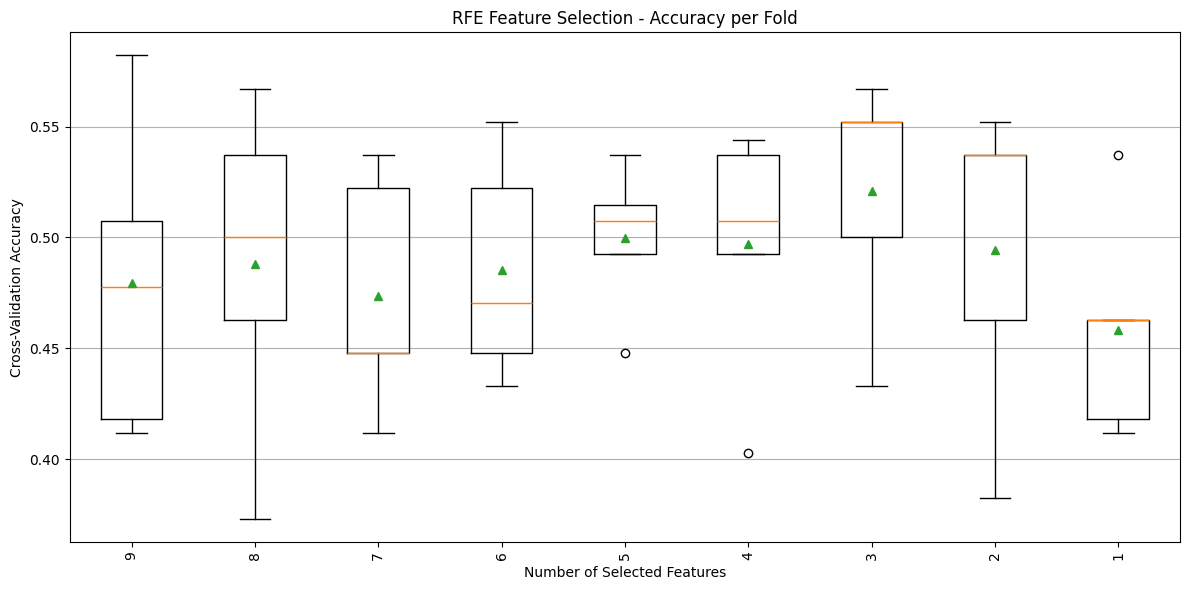

In [ ]:
plt.figure(figsize=(12, 6))
plt.boxplot(
    [cv_box_df[cv_box_df['n_features'] == n]['accuracy'] for n in sorted(cv_box_df['n_features'].unique(), reverse=True)],
    labels=sorted(cv_box_df['n_features'].unique(), reverse=True),
    showmeans=True
)
plt.xlabel("Number of Selected Features")
plt.ylabel("Cross-Validation Accuracy")
plt.title("RFE Feature Selection - Accuracy per Fold")
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
# prompt: rfe select for 1 feature

# Perform RFE
selector = RFE(estimator=model, n_features_to_select=1, step=1)
X_rfe_1_feature = selector.fit_transform(X, y)

# Get the name of the selected feature
selected_feature_index = selector.get_support(indices=True)[0]
selected_feature_name = feture_names[selected_feature_index]

print(f"Selected feature name: {selected_feature_name}")
print(f"Shape of the RFE transformed data with 1 feature: {X_rfe_1_feature.shape}")

# Optionally, you can evaluate the model with only this feature
scores_1_feature = cross_val_score(model, X_rfe_1_feature, y, cv=cv, scoring='accuracy')
print(f"Cross-validation accuracy with 1 feature: {scores_1_feature.mean():.4f} (+/- {scores_1_feature.std():.4f})")

Selected feature name: AUCTumor
Shape of the RFE transformed data with 1 feature: (421, 1)
Cross-validation accuracy with 1 feature: 0.5297 (+/- 0.0445)


# Label transform


In [ ]:
#Check the test_X information
test_X = df_X
test_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421 entries, 0 to 420
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Type             421 non-null    object 
 1   MAT              421 non-null    object 
 2   Targeting        421 non-null    object 
 3   Shape            421 non-null    object 
 4   Size             421 non-null    float64
 5   Zeta             421 non-null    float64
 6   Tumor_model      421 non-null    object 
 7   Cancer_type      421 non-null    object 
 8   Admin_frequency  421 non-null    object 
 9   Dose_1_total     421 non-null    float64
 10  Dose_2_total     421 non-null    float64
 11  Codelivery       421 non-null    object 
 12  Techen           421 non-null    object 
 13  AUCTumor         421 non-null    float64
dtypes: float64(5), object(9)
memory usage: 46.2+ KB


In [ ]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Columns label
categorical_columns = ['Type','MAT', 'Targeting', 'Shape', 'Tumor_model',
             'Cancer_type', 'Codelivery', 'Admin_frequency', 'Techen']
# Extract data
cat_data = test_X[categorical_columns]

# One hot encoder
cat_encoder = OneHotEncoder(sparse_output=False)
encoded = cat_encoder.fit_transform(cat_data)

# Trasfer dataset
data_cat_1hot = pd.DataFrame(encoded, columns=cat_encoder.get_feature_names_out(categorical_columns))
print(data_cat_1hot)

     Type_Hybrid  Type_Inorganic  Type_Organic  MAT_Dendrimer  MAT_Gold  \
0            0.0             0.0           1.0            0.0       0.0   
1            0.0             0.0           1.0            0.0       0.0   
2            0.0             0.0           1.0            0.0       0.0   
3            0.0             0.0           1.0            0.0       0.0   
4            0.0             0.0           1.0            0.0       0.0   
..           ...             ...           ...            ...       ...   
416          0.0             0.0           1.0            0.0       0.0   
417          0.0             0.0           1.0            0.0       0.0   
418          0.0             0.0           1.0            0.0       0.0   
419          0.0             1.0           0.0            0.0       0.0   
420          0.0             1.0           0.0            0.0       0.0   

     MAT_Hybrid  MAT_Hydrogel  MAT_In_Others  MAT_Iron_Oxide  MAT_Liposome  \
0           0.0      

In [ ]:
#Combine data
cols_num=["Size",
     "Zeta",
     "Dose_1_total",
     "Dose_2_total",
     "AUCTumor"]

preData = pd.concat([data_cat_1hot, test_X[cols_num]], axis=1)
preData.reset_index(drop=True, inplace=True)
print(preData.shape)
print(preData.head)

(421, 47)
<bound method NDFrame.head of      Type_Hybrid  Type_Inorganic  Type_Organic  MAT_Dendrimer  MAT_Gold  \
0            0.0             0.0           1.0            0.0       0.0   
1            0.0             0.0           1.0            0.0       0.0   
2            0.0             0.0           1.0            0.0       0.0   
3            0.0             0.0           1.0            0.0       0.0   
4            0.0             0.0           1.0            0.0       0.0   
..           ...             ...           ...            ...       ...   
416          0.0             0.0           1.0            0.0       0.0   
417          0.0             0.0           1.0            0.0       0.0   
418          0.0             0.0           1.0            0.0       0.0   
419          0.0             1.0           0.0            0.0       0.0   
420          0.0             1.0           0.0            0.0       0.0   

     MAT_Hybrid  MAT_Hydrogel  MAT_In_Others  MAT_Iron_Oxid

In [ ]:
# Transform the label to number for outprediction
from sklearn.preprocessing import LabelEncoder
#Define the type of feature
cols_label=['TGI_cat']# character
df_y["TGI_cat"] = df_y["TGI_cat"].map({"Low": 0, "High": 1})
print(df_y)

     TGI_cat
0          1
1          1
2          1
3          1
4          1
..       ...
416        0
417        0
418        1
419        0
420        1

[421 rows x 1 columns]


/tmp/ipython-input-614872576.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y["TGI_cat"] = df_y["TGI_cat"].map({"Low": 0, "High": 1})


##Data split

In [ ]:
#Check the shape
X = preData
y = df_y.values.ravel()
print(X.shape, y.shape)

(421, 47) (421,)


In [ ]:
##Split data to train set(80%) and test set (20%)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2, random_state=3407, stratify=y)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(336, 47)
(336,)
(85, 47)
(85,)


#Normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

#Column name
cols_num = ["Size", "Zeta", "Dose_1_total", "Dose_2_total", "AUCTumor"]

#MinMaxScaler
scaler = MinMaxScaler()

#Training set transform
X_train_scaled = X_train.copy()
X_train_scaled[cols_num] = scaler.fit_transform(X_train[cols_num])

#Test set
X_test_scaled = X_test.copy()
X_test_scaled[cols_num] = scaler.transform(X_test[cols_num])

#Print
print("Scaled training data preview:")
print(X_train_scaled.head())

print("\nScaled test data preview:")
print(X_test_scaled.head())


Scaled training data preview:
     Type_Hybrid  Type_Inorganic  Type_Organic  MAT_Dendrimer  MAT_Gold  \
175          0.0             0.0           1.0            0.0       0.0   
28           0.0             0.0           1.0            0.0       0.0   
218          0.0             0.0           1.0            0.0       0.0   
85           0.0             0.0           1.0            0.0       0.0   
14           0.0             1.0           0.0            0.0       0.0   

     MAT_Hybrid  MAT_Hydrogel  MAT_In_Others  MAT_Iron_Oxide  MAT_Liposome  \
175         0.0           0.0            0.0             0.0           0.0   
28          0.0           0.0            0.0             0.0           0.0   
218         0.0           0.0            0.0             0.0           0.0   
85          0.0           0.0            0.0             0.0           0.0   
14          0.0           0.0            0.0             0.0           0.0   

     ...  Codelivery_Single  Admin_frequency_Multi

In [ ]:
X_scaled = pd.concat([X_train_scaled, X_test_scaled], axis=0).sort_index()

print("Combined scaled data shape:", X_scaled.shape)
print(X_scaled.head())

Combined scaled data shape: (421, 47)
   Type_Hybrid  Type_Inorganic  Type_Organic  MAT_Dendrimer  MAT_Gold  \
0          0.0             0.0           1.0            0.0       0.0   
1          0.0             0.0           1.0            0.0       0.0   
2          0.0             0.0           1.0            0.0       0.0   
3          0.0             0.0           1.0            0.0       0.0   
4          0.0             0.0           1.0            0.0       0.0   

   MAT_Hybrid  MAT_Hydrogel  MAT_In_Others  MAT_Iron_Oxide  MAT_Liposome  ...  \
0         0.0           0.0            0.0             0.0           1.0  ...   
1         0.0           0.0            0.0             0.0           1.0  ...   
2         0.0           0.0            0.0             0.0           0.0  ...   
3         0.0           0.0            0.0             0.0           0.0  ...   
4         0.0           0.0            0.0             0.0           0.0  ...   

   Codelivery_Single  Admin_frequenc

#OPTUNA + Machine learning

##Evaluated function

In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model"):
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import matplotlib.cm as cm
    from sklearn.model_selection import StratifiedKFold, cross_val_score
    from sklearn.metrics import (
        roc_curve, auc, confusion_matrix,
        balanced_accuracy_score, f1_score, precision_score,
        recall_score, roc_auc_score
    )
    from sklearn.metrics import matthews_corrcoef, make_scorer

    mcc_scorer = make_scorer(matthews_corrcoef)

    print(f"\n=== Evaluation for: {model_name} ===")

    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores = {
        'Balanced Accuracy': cross_val_score(model, X_train, y_train, cv=cv, scoring='balanced_accuracy'),
        'F1 Score': cross_val_score(model, X_train, y_train, cv=cv, scoring='f1_macro'),
        'Precision': cross_val_score(model, X_train, y_train, cv=cv, scoring='precision_macro'),
        'Recall': cross_val_score(model, X_train, y_train, cv=cv, scoring='recall_macro'),
        'ROC AUC': cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc'),
        'MCC': cross_val_score(model, X_train, y_train, cv=cv, scoring=mcc_scorer)
    }


    # --- ROC curve per fold ---
    n_splits = 5
    colors = cm.get_cmap('Accent', n_splits)

    plt.figure(figsize=(7, 6))
    for i, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
        model.fit(X_train[train_idx], y_train[train_idx])
        y_val_prob = model.predict_proba(X_train[val_idx])[:, 1]
        fpr, tpr, _ = roc_curve(y_train[val_idx], y_val_prob)
        auc_fold = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2,color=colors(i), label=f"Fold {i+1} (AUC = {auc_fold:.3f})")

    # --- Fit on full train and evaluate on test ---
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    fpr_test, tpr_test, _ = roc_curve(y_test, y_prob)
    auc_test = auc(fpr_test, tpr_test)
    plt.plot(fpr_test, tpr_test, color='red', lw=3, linestyle='--', label=f"Test (AUC = {auc_test:.3f})")

    plt.plot([0, 1], [0, 1], color='black', linestyle=':')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {model_name}')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

    # --- Confusion matrix ---
    cm = confusion_matrix(y_test, y_pred)
    label_names = ['Low', 'High']
    plt.figure(figsize=(6, 4))
    cmap = sns.color_palette("coolwarm", as_cmap=True)
    ax = sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=True,
                     xticklabels=label_names, yticklabels=label_names, linewidths=0.65,
                     annot_kws={"size": 10, "color": "black"}, square=True, vmin=0, vmax=50)
    plt.xlabel("Predicted Classification", fontsize=12)
    plt.ylabel("Observed Classification", fontsize=12)
    plt.xticks(rotation=0, fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1.2)
    plt.tight_layout()
    plt.show()

    # --- Performance report ---
    test_scores = {
        'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred, average='macro', zero_division=0),
        'Precision': precision_score(y_test, y_pred, average='macro', zero_division=0),
        'Recall': recall_score(y_test, y_pred, average='macro', zero_division=0),
        'ROC AUC': roc_auc_score(y_test, y_prob),
        'MCC': matthews_corrcoef(y_test, y_pred)
    }

    print("\nTest Set Performance:")
    for metric, value in test_scores.items():
        print(f"{metric}: {value:.2f}")

    print("\nCross-Validation Performance:")
    for metric, values in cv_scores.items():
        print(f"{metric}: {values.mean():.2f} ± {values.std():.2f}")


##SVC

In [ ]:
import optuna
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

optuna.logging.set_verbosity(optuna.logging.ERROR)


# SVC
def objective(trial):
    param = {
        "C": trial.suggest_float("C", 1e-3, 1, log=True),
        "gamma": trial.suggest_float("gamma", 1e-4, 1.0, log=True),
        "kernel": trial.suggest_categorical("kernel", ["rbf", "poly", "sigmoid"]),
        # "degree": trial.suggest_int("degree", 2, 5)  # only used for poly kernel
    }

    model = SVC(**param, probability=True, random_state=42)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring="matthews_corrcoef")

    return scores.mean()

# Optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Output
print("Best parameters:", study.best_params)
print("Best score:", study.best_value)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-3507615561.py", line 1, in <cell line: 0>
    import optuna
  File "<frozen importlib._bootstrap>", line 1360, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1322, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 1262, in _find_spec
  File "<frozen importlib._bootstrap_external>", line 1532, in find_spec
  File "<frozen importlib._bootstrap_external>", line 1504, in _get_spec
  File "<frozen importlib._bootstrap_external>", line 1483, in _path_importer_cache
OSError: [Errno 107] Transport endpoint is not connected

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
   


=== Evaluation for: Support vector machine ===


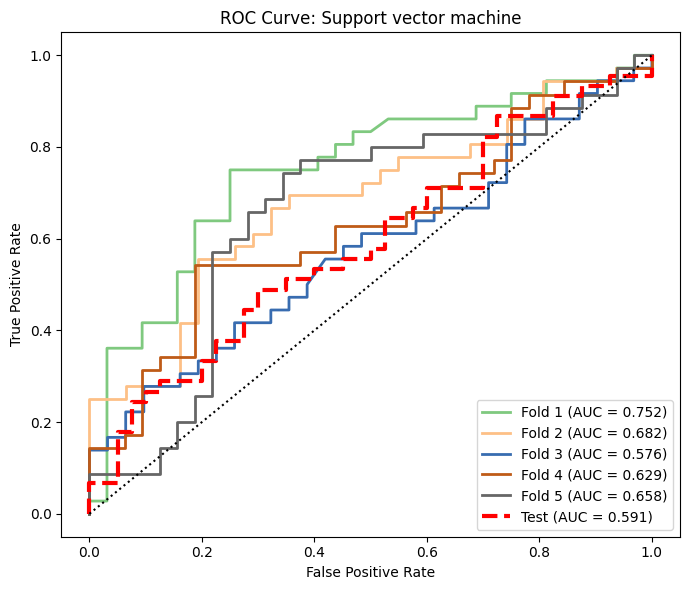

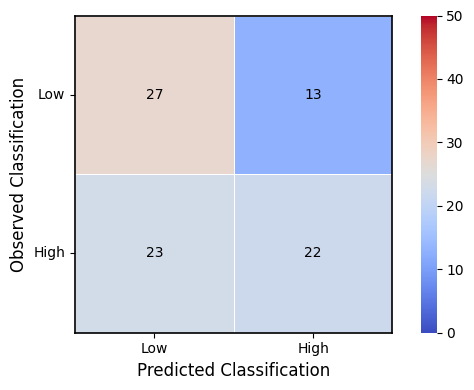


Test Set Performance:
Balanced Accuracy: 0.58
F1 Score: 0.57
Precision: 0.58
Recall: 0.58
ROC AUC: 0.59
MCC: 0.17

Cross-Validation Performance:
Balanced Accuracy: 0.64 ± 0.07
F1 Score: 0.64 ± 0.07
Precision: 0.64 ± 0.07
Recall: 0.64 ± 0.07
ROC AUC: 0.66 ± 0.06
MCC: 0.28 ± 0.14


In [ ]:
### Develop the best model
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
import pandas as pd

svc_best_params = study.best_params
SVC = SVC(**svc_best_params,probability=True, random_state=42)
evaluate_model(SVC, X_train_scaled, y_train, X_test_scaled, y_test, model_name="Support vector machine")

##KNN

In [ ]:
import optuna
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.ERROR)

# KNN
def objective(trial):
    param = {
        "n_neighbors": trial.suggest_int("n_neighbors", 3, 25),
        "weights": trial.suggest_categorical("weights", ["uniform", "distance"]),
        # "metric": trial.suggest_categorical("metric", ["euclidean", "manhattan", "minkowski"]),
        "p": trial.suggest_int("p", 1, 5)
    }

    model = KNeighborsClassifier(**param)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring="matthews_corrcoef")

    return scores.mean()

# Optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

#Output
print("Best parameters:", study.best_params)
print("Best score:", study.best_value)


Best parameters: {'n_neighbors': 5, 'weights': 'distance', 'p': 3}
Best score: 0.24638219702613456



=== Evaluation for: KNN ===


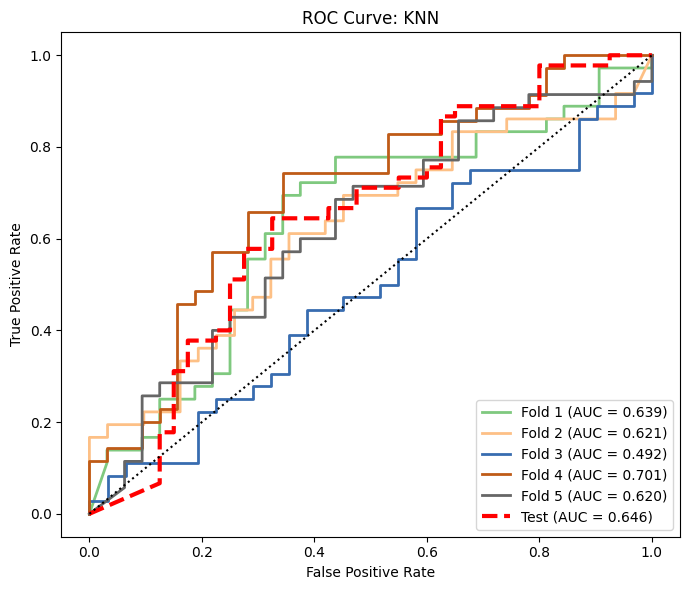

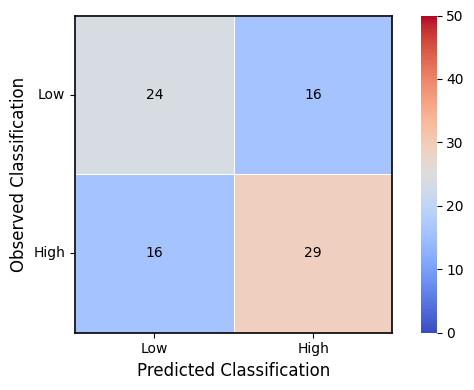


Test Set Performance:
Balanced Accuracy: 0.62
F1 Score: 0.62
Precision: 0.62
Recall: 0.62
ROC AUC: 0.65
MCC: 0.24

Cross-Validation Performance:
Balanced Accuracy: 0.62 ± 0.06
F1 Score: 0.62 ± 0.06
Precision: 0.62 ± 0.06
Recall: 0.62 ± 0.06
ROC AUC: 0.61 ± 0.07
MCC: 0.25 ± 0.12


In [ ]:
### Develop the best model
KNN_best_params = study.best_params
KNN = KNeighborsClassifier(**KNN_best_params)
evaluate_model(KNN, X_train_scaled, y_train, X_test_scaled, y_test, model_name="KNN")

##RF

In [ ]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
optuna.logging.set_verbosity(optuna.logging.ERROR)

#Random forest model
def objective(trial):
    param = {
        "max_depth": trial.suggest_int("max_depth", 10, 30),
        "max_features": trial.suggest_float("max_features", 0.1, 1.0),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 8),
    }
    model = RandomForestClassifier(**param, random_state=42)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring="matthews_corrcoef")

    return scores.mean()

# Optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

#Output
print("Best parameters:", study.best_params)
print("Best score:", study.best_value)

Best parameters: {'max_depth': 19, 'max_features': 0.13978129807393344, 'n_estimators': 130, 'min_samples_split': 4, 'min_samples_leaf': 1}
Best accuracy score: 0.2901528986318998



=== Evaluation for: Random Forest ===


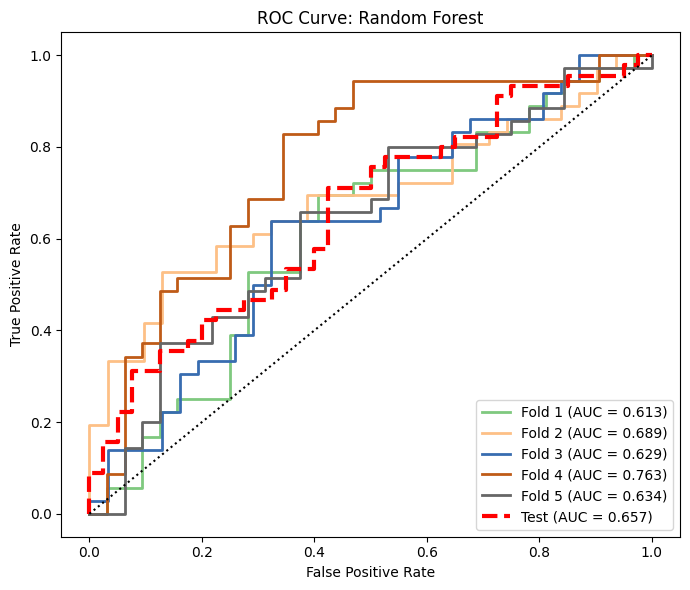

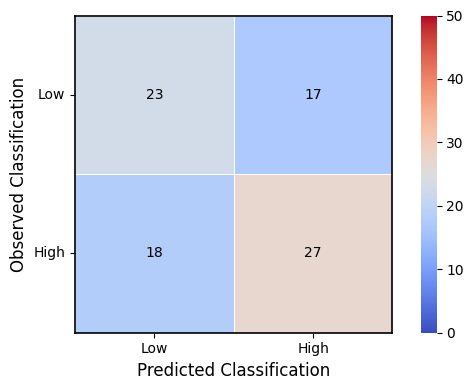


Test Set Performance:
Balanced Accuracy: 0.59
F1 Score: 0.59
Precision: 0.59
Recall: 0.59
ROC AUC: 0.66
MCC: 0.17

Cross-Validation Performance:
Balanced Accuracy: 0.64 ± 0.04
F1 Score: 0.64 ± 0.04
Precision: 0.65 ± 0.04
Recall: 0.64 ± 0.04
ROC AUC: 0.67 ± 0.06
MCC: 0.29 ± 0.07


In [ ]:
### Develop the best model
rf_best_params = study.best_params
rf = RandomForestClassifier(**rf_best_params, random_state=42)
rf.fit(X_train, y_train)
#Model evaluate
evaluate_model(rf, X_train_scaled, y_train, X_test_scaled, y_test, model_name="Random Forest")

##XGBoost

In [ ]:
!pip install xgboost==3.0.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.8/253.8 MB 5.5 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 3.1.1
    Uninstalling xgboost-3.1.1:
      Successfully uninstalled xgboost-3.1.1


In [ ]:
from re import VERBOSE
import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer
optuna.logging.set_verbosity(optuna.logging.ERROR)

# XGB
def objective(trial):
    param = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 4, 8),
        "gamma": trial.suggest_float("gamma", 0, 10.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-10, 1e-6, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-6, 1e-3, log=True),
        "eval_metric": "auc",
        "random_state": 42
    }


    model = XGBClassifier(**param)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring="matthews_corrcoef")
    return scores.mean()

#Optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

#Output
print("Best parameters:", study.best_params)
print("Best score:", study.best_value)

Best parameters: {'learning_rate': 0.12126944471748878, 'n_estimators': 783, 'max_depth': 4, 'colsample_bytree': 0.954152187147504, 'subsample': 0.8196674509151544, 'min_child_weight': 6, 'gamma': 2.6646063216283, 'reg_alpha': 1.3641997442097796e-09, 'reg_lambda': 4.784608040237875e-06}
Best score: 0.2610462258893568



=== Evaluation for: XGB ===


/tmp/ipython-input-4025860924.py:37: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



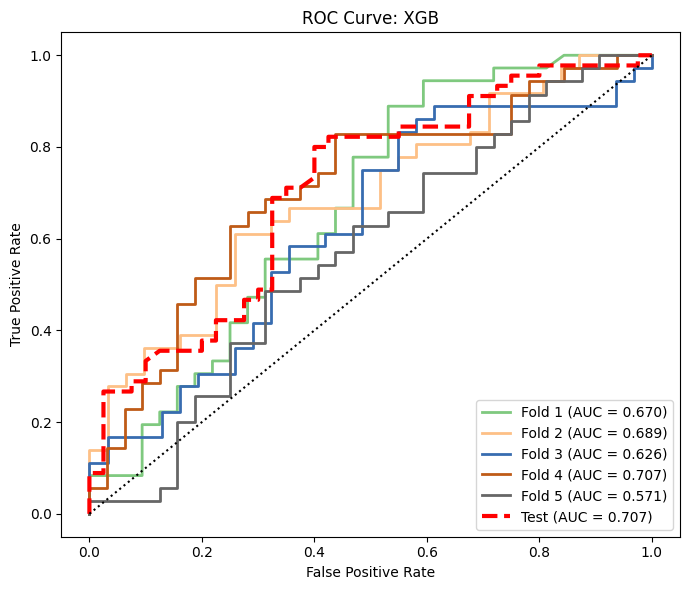

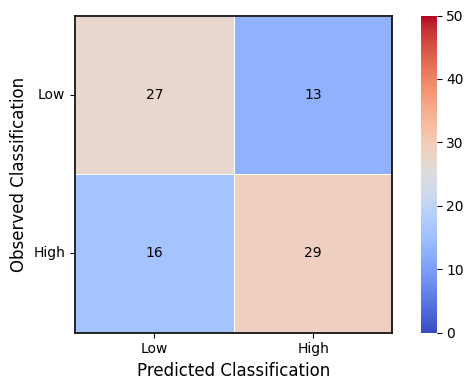


Test Set Performance:
Balanced Accuracy: 0.66
F1 Score: 0.66
Precision: 0.66
Recall: 0.66
ROC AUC: 0.71
MCC: 0.32

Cross-Validation Performance:
Balanced Accuracy: 0.61 ± 0.05
F1 Score: 0.61 ± 0.05
Precision: 0.62 ± 0.05
Recall: 0.61 ± 0.05
ROC AUC: 0.65 ± 0.05
MCC: 0.23 ± 0.09


In [ ]:
### Develop the best model
XGB_best_params = study.best_params
XGB = XGBClassifier(**XGB_best_params)
#Evaluate model
evaluate_model(XGB, X_train_scaled, y_train, X_test_scaled, y_test, model_name="XGB")

In [ ]:
#Save the model
import joblib

XGB_model = XGBClassifier(**XGB_best_params)
XGB_model.fit(X_train_scaled, y_train)

joblib.dump(XGB_model, "xgb_model-20251112.pkl")

['xgb_model-20251112.pkl']

##LGBM

In [ ]:
import optuna
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.ERROR)
# LGBM
def objective(trial):
    param = {
    "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15, log=True),
    "max_depth": trial.suggest_int("max_depth", 3, 6),
    "num_leaves": trial.suggest_int("num_leaves", 7, 31),
    "subsample": trial.suggest_float("subsample", 0.6, 1.0),
    # "feature_fraction":  trial.suggest_float("feature_fraction", 0.5, 1.0),
    # "min_split_gain": trial.suggest_float("min_split_gain", 0, 0.1),
    "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
    "n_estimators": trial.suggest_int("n_estimators", 300, 1200),
    "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 5.0, log=True),
    "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 5.0, log=True),
    "min_child_samples": trial.suggest_int("min_child_samples", 10, 50)
    }

    model = LGBMClassifier(**param, random_state=42, verbose=-1, n_jobs=-1)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring="matthews_corrcoef")

    return scores.mean()

# Optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Output
print("Best parameters:", study.best_params)
print("Best score:", study.best_value)


Best parameters: {'learning_rate': 0.052073862040605906, 'max_depth': 4, 'num_leaves': 19, 'subsample': 0.6000022655518107, 'feature_fraction': 0.6126160462238845, 'colsample_bytree': 0.621281059928288, 'n_estimators': 1061, 'reg_alpha': 0.08466556811073865, 'reg_lambda': 0.0025876541918112093, 'min_child_samples': 39}
Best score: 0.28370851519229706



=== Evaluation for: LGBM ===


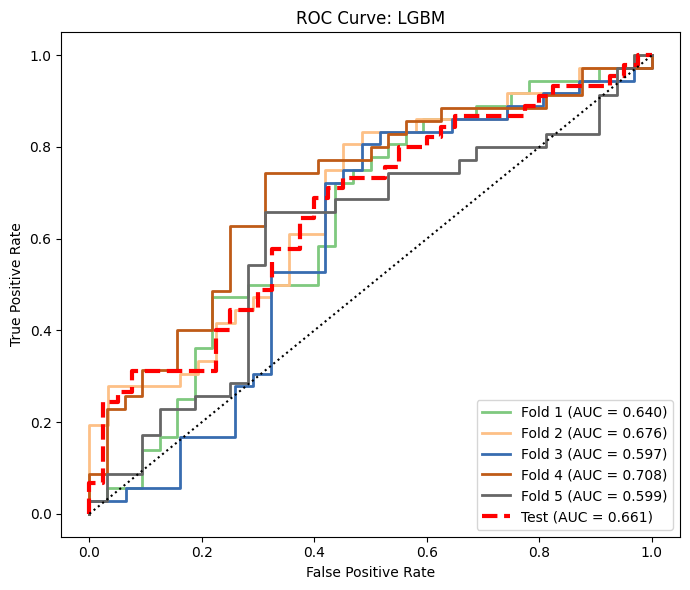

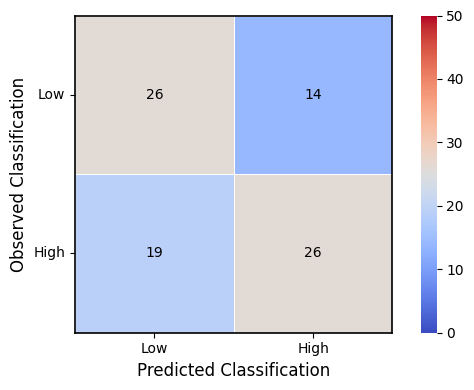


Test Set Performance:
Balanced Accuracy: 0.61
F1 Score: 0.61
Precision: 0.61
Recall: 0.61
ROC AUC: 0.66
MCC: 0.23

Cross-Validation Performance:
Balanced Accuracy: 0.64 ± 0.03
F1 Score: 0.64 ± 0.03
Precision: 0.64 ± 0.04
Recall: 0.64 ± 0.03
ROC AUC: 0.64 ± 0.04
MCC: 0.28 ± 0.07


In [ ]:
### Develop the best model
from sklearn.metrics import roc_curve, auc

LGBM_best_params = study.best_params
LGBM = LGBMClassifier(**LGBM_best_params, random_state=42,verbose=-1, n_jobs=-1)
#Model evaluate
evaluate_model(LGBM, X_train_scaled, y_train, X_test_scaled, y_test, model_name="LGBM")

##Gradient Boosting Classifier

In [ ]:
import optuna
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Suppress Optuna logs
optuna.logging.set_verbosity(optuna.logging.ERROR)

# Define Optuna objective function
def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    }

    model = GradientBoostingClassifier(**params, random_state=42)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring="matthews_corrcoef")

    return scores.mean()

# Create and run Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Output results
print("Best parameters:", study.best_params)
print("Best accuracy:", study.best_value)

Best parameters: {'learning_rate': 0.11414350675943882, 'n_estimators': 821, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 3, 'subsample': 0.863870594982666, 'max_features': None}
Best accuracy: 0.277625035155435



=== Evaluation for: GBoost ===


/tmp/ipython-input-4025860924.py:37: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



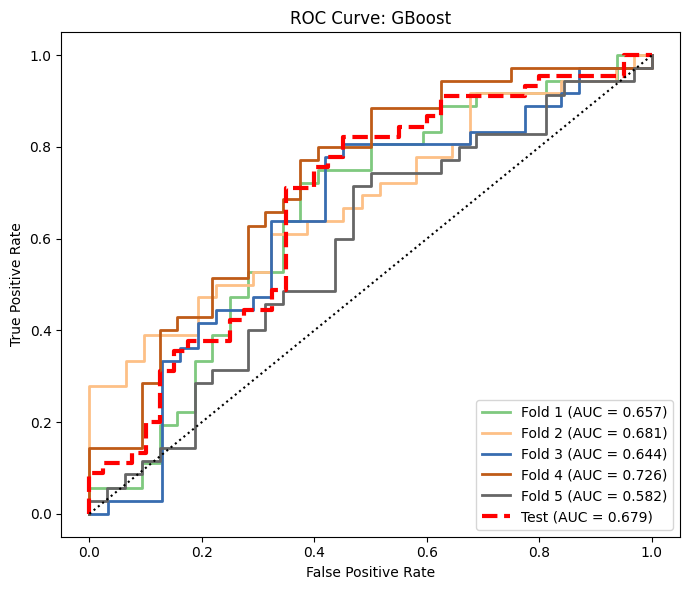

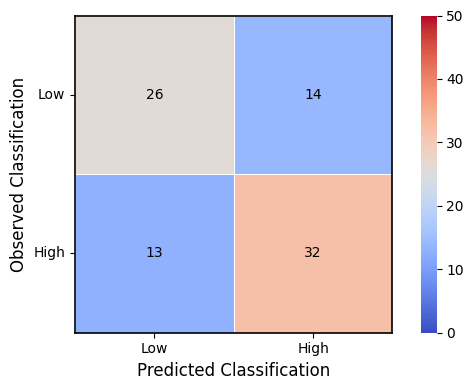


Test Set Performance:
Balanced Accuracy: 0.68
F1 Score: 0.68
Precision: 0.68
Recall: 0.68
ROC AUC: 0.68
MCC: 0.36

Cross-Validation Performance:
Balanced Accuracy: 0.64 ± 0.03
F1 Score: 0.64 ± 0.03
Precision: 0.64 ± 0.02
Recall: 0.64 ± 0.03
ROC AUC: 0.66 ± 0.05
MCC: 0.28 ± 0.05


In [ ]:
### Develop the best model
GBoost_best_params = study.best_params
GBoost = GradientBoostingClassifier(**GBoost_best_params, random_state=42)
GBoost.fit(X_train, y_train)
#Model evaluate
evaluate_model(GBoost, X_train_scaled, y_train, X_test_scaled, y_test, model_name="GBoost")

In [ ]:
#Save the model
import joblib

GBC_model = GradientBoostingClassifier(**GBoost_best_params, random_state=42)
GBC_model.fit(X_train_scaled, y_train)

joblib.dump(GBC_model, "GBC_model-20251112.pkl")

['GBC_model-20251112.pkl']

##Extra Trees

In [ ]:
import optuna
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# Silence Optuna logging
optuna.logging.set_verbosity(optuna.logging.ERROR)

# Define the Optuna objective function
def objective(trial):
    # Define hyperparameter search space
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 5, 50),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_float("max_features", 0.1, 1.0)
    }

    # Initialize and train model
    model = ExtraTreesClassifier(**params, random_state=42, n_jobs=-1)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring="matthews_corrcoef")

    return scores.mean()

# Create and optimize Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Show results
print("Best parameters:", study.best_params)
print("Best accuracy:", study.best_value)


Best parameters: {'n_estimators': 383, 'max_depth': 20, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': 0.6993310275805138}
Best accuracy: 0.2513092596811504



=== Evaluation for: Extra_Tree ===


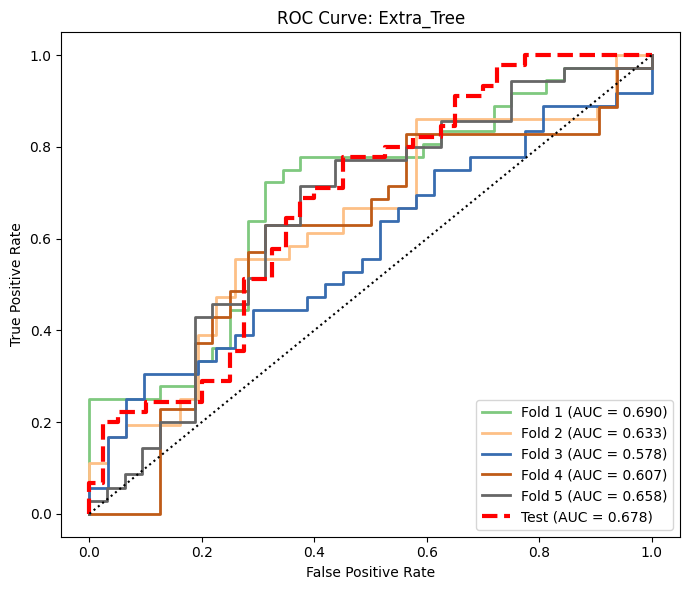

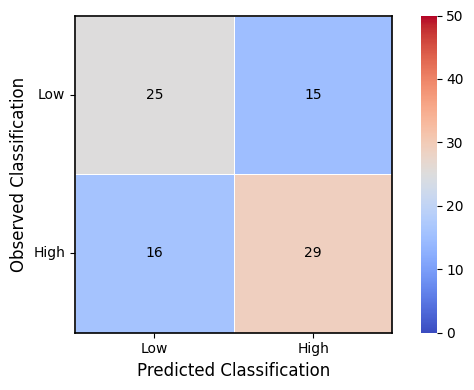


Test Set Performance:
Balanced Accuracy: 0.63
F1 Score: 0.63
Precision: 0.63
Recall: 0.63
ROC AUC: 0.68
MCC: 0.27

Cross-Validation Performance:
Balanced Accuracy: 0.63 ± 0.06
F1 Score: 0.62 ± 0.06
Precision: 0.63 ± 0.06
Recall: 0.63 ± 0.06
ROC AUC: 0.63 ± 0.04
MCC: 0.25 ± 0.11


In [ ]:
### Develop the best model
Extra_Tree_best_params = study.best_params
Extra_Tree = ExtraTreesClassifier(**Extra_Tree_best_params, random_state=42)
#Model evaluate
evaluate_model(Extra_Tree, X_train_scaled, y_train, X_test_scaled, y_test, model_name="Extra_Tree")

##Catboost

In [ ]:
import optuna
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Suppress Optuna logs
optuna.logging.set_verbosity(optuna.logging.ERROR)

# Define Optuna objective function
def objective(trial):
    params = {
    "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
    "depth": trial.suggest_int("depth", 4, 10),
    "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 1.0, log=True),
    "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
    "random_strength": trial.suggest_float("random_strength", 1e-8, 1.0, log=True),
    "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 10.0),
    "verbose": False
    }

    model = CatBoostClassifier(**params, random_state=42)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring="matthews_corrcoef")

    return scores.mean()

# Create and run Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Output results
print("Best parameters:", study.best_params)
print("Best accuracy:", study.best_value)


Best parameters: {'learning_rate': 0.017799779329549358, 'depth': 10, 'l2_leaf_reg': 0.48625997563167095, 'bootstrap_type': 'Bayesian', 'random_strength': 0.003290271387381723, 'bagging_temperature': 0.4461618993766271}
Best accuracy: 0.2979070004671291



=== Evaluation for: CatBoost ===


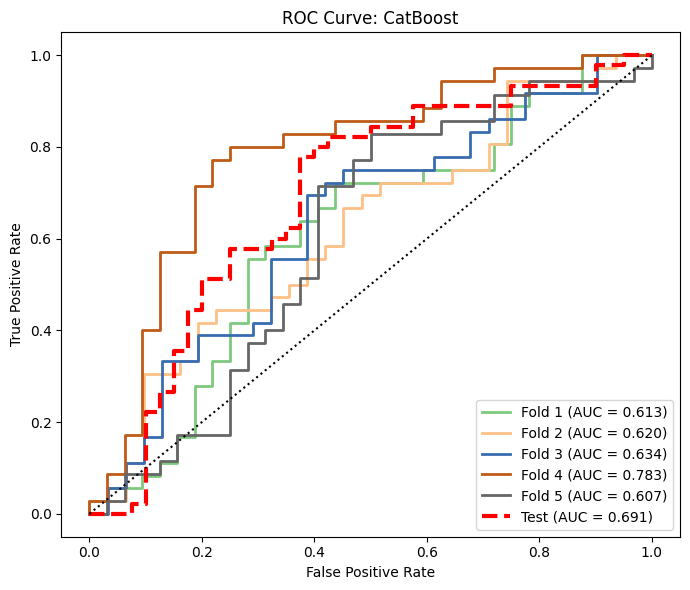

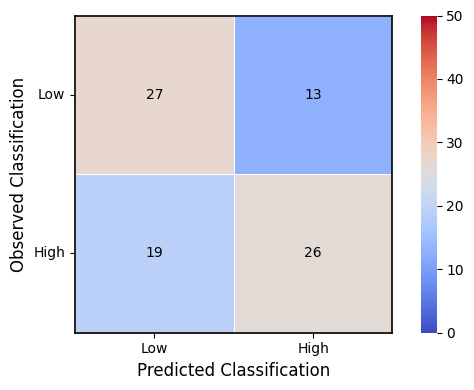


Test Set Performance:
Balanced Accuracy: 0.63
F1 Score: 0.62
Precision: 0.63
Recall: 0.63
ROC AUC: 0.69
MCC: 0.25

Cross-Validation Performance:
Balanced Accuracy: 0.65 ± 0.06
F1 Score: 0.65 ± 0.06
Precision: 0.65 ± 0.06
Recall: 0.65 ± 0.06
ROC AUC: 0.65 ± 0.07
MCC: 0.30 ± 0.12


In [ ]:
### Develop the best model
Cat_best_params = study.best_params
CatBoost= CatBoostClassifier(**Cat_best_params, random_state=42, verbose=0)
#Model evaluate
evaluate_model(CatBoost, X_train_scaled, y_train, X_test_scaled, y_test, model_name="CatBoost")

In [ ]:
# #Save the model
# import joblib

CatBoost= CatBoostClassifier(**Cat_best_params, random_state=42, verbose=0)
CatBoost.fit(X_train_scaled, y_train)

joblib.dump(CatBoost, "CatBoost-20251112.pkl")

['CatBoost-20251112.pkl']

# Deep nerual network model

## Tuning DNN Model with Optuna

In [ ]:
# import basic packages
import optuna
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
import keras_tuner as kt
#import scikeras
from tensorflow import keras
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import matplotlib as mpl
from sklearn.model_selection import RepeatedKFold

# import keras related packages
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras import regularizers
from keras.regularizers import l2
from keras.optimizers import SGD, Adam
#from keras.optimizers.schedules import ExponentialDecay
from keras.models import load_model
from keras.callbacks import EarlyStopping
from tensorflow import keras
from keras import layers
from keras_tuner import BayesianOptimization

In [ ]:
#Check the shape
X = preData
y = df_y.values.ravel()
print(X.shape, y.shape)

(421, 47) (421,)


In [ ]:
# Split raw data
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Scale only numerical columns
scaler = MinMaxScaler()
scaler.fit(X_temp[cols_num])

X_temp_scaled = X_temp.copy()
X_test_scaled = X_test.copy()

X_temp_scaled[cols_num] = scaler.transform(X_temp[cols_num])
X_test_scaled[cols_num] = scaler.transform(X_test[cols_num])

#Train/Validation split
X_train_scaled, X_val_scaled, y_train, y_valid = train_test_split(
    X_temp_scaled, y_temp, test_size=0.1, random_state=42
)

#Print Shape
print("Train:", X_train_scaled.shape)
print("Val:",   X_val_scaled.shape)
print("Test:",  X_test_scaled.shape)
print("y_train:", y_train.shape)
print("y_val:", y_valid.shape)


Train: (302, 47)
Val: (34, 47)
Test: (85, 47)
y_train: (302,)
y_val: (34,)


In [ ]:
#DNN structure and hyperparameter

def build_model(trial):

    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid'])
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    num_layers = trial.suggest_int('num_dense_layers', 1, 3)

    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))


    units_input = trial.suggest_int('units_input', 32, 128, step=32)
    model.add(Dense(units_input, activation=activation, kernel_regularizer=l2(weight_decay)))


    for i in range(num_layers):
        units = trial.suggest_int(f'units_{i}', 32, 512, step=32)
        dropout_rate = trial.suggest_float(f'dropout_{i}', 0.0, 0.5, step=0.1)
        model.add(Dense(units, activation=activation, kernel_regularizer=l2(weight_decay)))
        model.add(Dropout(dropout_rate))


    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(weight_decay)))


    optimizer_choice = trial.suggest_categorical('optimizer', ['Adam', 'SGD'])
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    if optimizer_choice == 'Adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'SGD':
        momentum = trial.suggest_float("sgd_momentum", 0.0, 0.95)
        optimizer = SGD(learning_rate=learning_rate, momentum=momentum, nesterov=True)

    #
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import matthews_corrcoef
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

def objective_cv(trial):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    mcc_list = []

    for train_idx, val_idx in skf.split(X_temp_scaled, y_temp):
        X_train_cv, X_val_cv = X_temp_scaled.iloc[train_idx], X_temp_scaled.iloc[val_idx]
        y_train_cv, y_val_cv = y_temp[train_idx], y_temp[val_idx]

        model = build_model(trial)
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)

        model.fit(
            X_train_cv, y_train_cv,
            validation_data=(X_val_cv, y_val_cv),
            epochs=128,
            batch_size=32,
            callbacks=[early_stop],
            verbose=0
        )

        y_pred = (model.predict(X_val_cv) > 0.5).astype(int)
        mcc_list.append(matthews_corrcoef(y_val_cv, y_pred))

    return np.mean(mcc_list)


In [ ]:
from optuna.pruners import MedianPruner

study = optuna.create_study(direction='maximize')
study.optimize(objective_cv, n_trials=10)

print("Best trial:")
print("  score:", study.best_trial.value)
print("  Params:")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

[I 2025-11-13 20:28:20,242] A new study created in memory with name: no-name-87b510a1-cb7f-4b9b-8ac8-0e9fd249d091


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


[I 2025-11-13 20:29:55,878] Trial 0 finished with value: 0.18013009537629848 and parameters: {'activation': 'relu', 'weight_decay': 0.0004567309598853158, 'num_dense_layers': 2, 'units_input': 32, 'units_0': 224, 'dropout_0': 0.5, 'units_1': 192, 'dropout_1': 0.1, 'optimizer': 'Adam', 'learning_rate': 5.129585615016935e-05}. Best is trial 0 with value: 0.18013009537629848.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


[I 2025-11-13 20:30:22,066] Trial 1 finished with value: 0.10874610991330609 and parameters: {'activation': 'relu', 'weight_decay': 0.00021027097616391113, 'num_dense_layers': 3, 'units_input': 64, 'units_0': 384, 'dropout_0': 0.4, 'units_1': 384, 'dropout_1': 0.5, 'units_2': 416, 'dropout_2': 0.2, 'optimizer': 'Adam', 'learning_rate': 0.0030189475263207263}. Best is trial 0 with value: 0.18013009537629848.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


[I 2025-11-13 20:30:37,767] Trial 2 finished with value: 0.10192276620545948 and parameters: {'activation': 'tanh', 'weight_decay': 4.569931803281088e-06, 'num_dense_layers': 1, 'units_input': 128, 'units_0': 128, 'dropout_0': 0.30000000000000004, 'optimizer': 'Adam', 'learning_rate': 0.004085947750902937}. Best is trial 0 with value: 0.18013009537629848.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


[I 2025-11-13 20:31:22,814] Trial 3 finished with value: 0.16555543468796802 and parameters: {'activation': 'tanh', 'weight_decay': 0.000543485421248569, 'num_dense_layers': 3, 'units_input': 128, 'units_0': 32, 'dropout_0': 0.1, 'units_1': 416, 'dropout_1': 0.5, 'units_2': 320, 'dropout_2': 0.5, 'optimizer': 'SGD', 'learning_rate': 0.005243171630864162, 'sgd_momentum': 0.49191311646707286}. Best is trial 0 with value: 0.18013009537629848.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


[I 2025-11-13 20:33:22,767] Trial 4 finished with value: 0.17581795996685493 and parameters: {'activation': 'tanh', 'weight_decay': 5.899536327122058e-05, 'num_dense_layers': 1, 'units_input': 64, 'units_0': 128, 'dropout_0': 0.0, 'optimizer': 'SGD', 'learning_rate': 0.0017969912340816056, 'sgd_momentum': 0.3716248958966015}. Best is trial 0 with value: 0.18013009537629848.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


[I 2025-11-13 20:34:33,256] Trial 5 finished with value: 0.09898490451801001 and parameters: {'activation': 'relu', 'weight_decay': 1.1294578903804445e-06, 'num_dense_layers': 3, 'units_input': 96, 'units_0': 160, 'dropout_0': 0.2, 'units_1': 224, 'dropout_1': 0.1, 'units_2': 64, 'dropout_2': 0.5, 'optimizer': 'SGD', 'learning_rate': 0.0007351484747061234, 'sgd_momentum': 0.9355826825131822}. Best is trial 0 with value: 0.18013009537629848.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2025-11-13 20:35:02,137] Trial 6 finished with value: 0.17817820905140852 and parameters: {'activation': 'tanh', 'weight_decay': 0.0005456097420362923, 'num_dense_layers': 3, 'units_input': 64, 'units_0': 128, 'dropout_0': 0.4, 'units_1': 192, 'dropout_1': 0.30000000000000004, 'units_2': 128, 'dropout_2': 0.30000000000000004, 'optimizer': 'Adam', 'learning_rate': 0.006933172126929241}. Best is trial 0 with value: 0.18013009537629848.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


[I 2025-11-13 20:36:38,926] Trial 7 finished with value: -0.007033799484533298 and parameters: {'activation': 'sigmoid', 'weight_decay': 0.0039505136556286695, 'num_dense_layers': 1, 'units_input': 96, 'units_0': 256, 'dropout_0': 0.4, 'optimizer': 'SGD', 'learning_rate': 0.0022433369811284483, 'sgd_momentum': 0.39569998490796676}. Best is trial 0 with value: 0.18013009537629848.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[I 2025-11-13 20:38:11,302] Trial 8 finished with value: 0.06214684895317017 and parameters: {'activation': 'relu', 'weight_decay': 9.358875411798662e-06, 'num_dense_layers': 3, 'units_input': 128, 'units_0': 96, 'dropout_0': 0.0, 'units_1': 256, 'dropout_1': 0.30000000000000004, 'units_2': 96, 'dropout_2': 0.5, 'optimizer': 'SGD', 'learning_rate': 0.0006584800001418414, 'sgd_momentum': 0.8957443955847878}. Best is trial 0 with value: 0.18013009537629848.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


[I 2025-11-13 20:38:36,968] Trial 9 finished with value: 0.0 and parameters: {'activation': 'sigmoid', 'weight_decay': 1.9450866925854724e-06, 'num_dense_layers': 3, 'units_input': 32, 'units_0': 448, 'dropout_0': 0.0, 'units_1': 256, 'dropout_1': 0.1, 'units_2': 64, 'dropout_2': 0.4, 'optimizer': 'SGD', 'learning_rate': 0.0010480834026049227, 'sgd_momentum': 0.7093492043524494}. Best is trial 0 with value: 0.18013009537629848.


Best trial:
  score: 0.18013009537629848
  Params:
    activation: relu
    weight_decay: 0.0004567309598853158
    num_dense_layers: 2
    units_input: 32
    units_0: 224
    dropout_0: 0.5
    units_1: 192
    dropout_1: 0.1
    optimizer: Adam
    learning_rate: 5.129585615016935e-05


In [ ]:
best_params = study.best_params
print("Best hyperparameters:", best_params)

Best hyperparameters: {'activation': 'relu', 'weight_decay': 0.0004567309598853158, 'num_dense_layers': 2, 'units_input': 32, 'units_0': 224, 'dropout_0': 0.5, 'units_1': 192, 'dropout_1': 0.1, 'optimizer': 'Adam', 'learning_rate': 5.129585615016935e-05}


In [ ]:
def build_model_from_params(params):
    model = Sequential()

    model.add(Input(shape=(X_train.shape[1],)))
    activation    = params['activation']
    weight_decay  = params['weight_decay']
    model.add(
        Dense(params['units_input'],activation=activation,kernel_regularizer=l2(weight_decay))
    )
    num_layers = params['num_dense_layers']
    for i in range(num_layers):
        model.add(Dense(params[f'units_{i}'],activation=activation,kernel_regularizer=l2(weight_decay))
        )
        model.add(Dropout(params[f'dropout_{i}']))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(weight_decay)))

    if params['optimizer'] == 'Adam':
        optimizer = Adam(learning_rate=params['learning_rate'])
    else:  # SGD
        optimizer = SGD(
            learning_rate=params['learning_rate'],
            momentum=params['sgd_momentum'],
            nesterov=True
        )

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

/tmp/ipython-input-447952220.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('Accent', n_splits)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


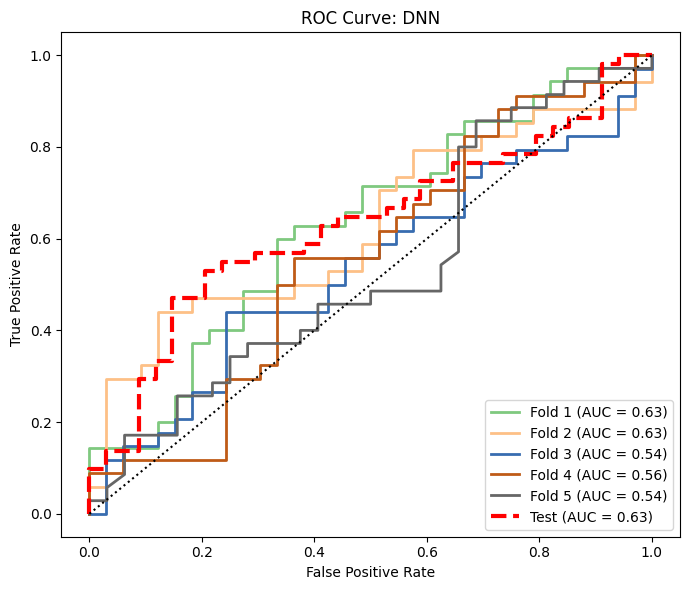

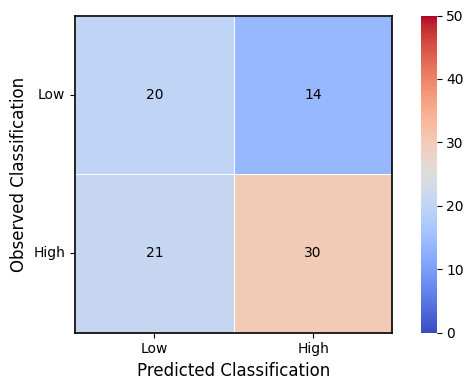

Cross‑Validation Performance:
Accuracy: 0.55 ± 0.04
Balanced Accuracy: 0.55 ± 0.04
F1 Score: 0.55 ± 0.04
Precision: 0.55 ± 0.04
Recall: 0.55 ± 0.04
ROC AUC: 0.58 ± 0.04
MCC: 0.10 ± 0.08

Test Set Performance:
Accuracy: 0.59
Balanced Accuracy: 0.59
F1 Score: 0.58
Precision: 0.58
Recall: 0.59
ROC AUC: 0.63
MCC: 0.17


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    precision_score, recall_score, roc_auc_score, matthews_corrcoef,
    roc_curve, confusion_matrix
)
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np

# Assume build_model_from_params, best_params, model_name, X_train, y_train, X_test, y_test are defined

#Set up stratified 5-fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
n_splits = cv.get_n_splits()

# Prepare lists to collect per-fold metrics
accs, bals, f1s, precs, recs, aucs, mccs = [], [], [], [], [], [], []

# Initialize ROC figure with one extra color for the test set
plt.figure(figsize=(7, 6))
colors = cm.get_cmap('Accent', n_splits)

#Cross‑validation loop: train, evaluate, and plot fold ROC
for i, (train_idx, val_idx) in enumerate(cv.split(X_temp_scaled, y_temp)):
    # Split data for this fold
    X_tr, X_val = X_temp_scaled.iloc[train_idx], X_temp_scaled.iloc[val_idx]
    y_tr, y_val = y_temp[train_idx], y_temp[val_idx]

    # Build and compile a fresh model
    cv_model = build_model_from_params(best_params)
    cv_model.compile(optimizer=cv_model.optimizer, loss='binary_crossentropy')

    # Train with early stopping
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')
    cv_model.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val),
        epochs=128,
        batch_size=best_params.get('batch_size', 32),
        callbacks=[es],
        verbose=0
    )

    # Predict probabilities and classes
    y_val_prob = cv_model.predict(X_val).ravel()
    y_val_pred = (y_val_prob > 0.5).astype(int)

    # Compute and store metrics
    accs.append(accuracy_score(y_val, y_val_pred))
    bals.append(balanced_accuracy_score(y_val, y_val_pred))
    f1s.append(f1_score(y_val, y_val_pred, average='macro', zero_division=0))
    precs.append(precision_score(y_val, y_val_pred, average='macro', zero_division=0))
    recs.append(recall_score(y_val, y_val_pred, average='macro', zero_division=0))
    try:
        aucs.append(roc_auc_score(y_val, y_val_prob))
    except ValueError:
        aucs.append(np.nan)
    mccs.append(matthews_corrcoef(y_val, y_val_pred))

    # Plot ROC for this fold
    fpr, tpr, _ = roc_curve(y_val, y_val_prob)
    plt.plot(
        fpr, tpr,
        color=colors(i),
        lw=2,
        label=f"Fold {i+1} (AUC = {aucs[-1]:.2f})"
    )

#Retrain on full training data and evaluate on test set
model = build_model_from_params(best_params)

model.compile(optimizer=model.optimizer, loss='binary_crossentropy')


model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_valid),
    epochs=128,
    batch_size=best_params.get('batch_size', 32),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')],
    verbose=0
)

# Predict on test set
y_test_prob = model.predict(X_test_scaled).ravel()
y_test_pred = (y_test_prob > 0.5).astype(int)

# Compute and plot test ROC
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
auc_test = roc_auc_score(y_test, y_test_prob)
plt.plot(
    fpr_test, tpr_test,
    color='red',
    lw=3,
    linestyle='--',
    label=f"Test (AUC = {auc_test:.2f})"
)

# Add diagonal reference line and finalize plot
plt.plot([0, 1], [0, 1], color='black', linestyle=':')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve: DNN")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# 6. Plot confusion matrix on test set
cmat = confusion_matrix(y_test, y_test_pred)
label_names = ['Low', 'High']
plt.figure(figsize=(6, 4))
ax = sns.heatmap(
    cmat, annot=True, fmt='d', cmap='coolwarm', cbar=True,
    xticklabels=label_names, yticklabels=label_names,
    linewidths=0.65, annot_kws={"size": 10, "color": "black"},
    square=True, vmin=0, vmax=50
)
plt.xlabel("Predicted Classification", fontsize=12)
plt.ylabel("Observed Classification", fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1.2)
plt.tight_layout()
plt.show()

#Print CV performance
print("Cross‑Validation Performance:")
cv_metrics = {
    "Accuracy": accs,
    "Balanced Accuracy": bals,
    "F1 Score": f1s,
    "Precision": precs,
    "Recall": recs,
    "ROC AUC": aucs,
    "MCC": mccs
}
for name, vals in cv_metrics.items():
    vals = np.array(vals, dtype=np.float64)
    print(f"{name}: {np.nanmean(vals):.2f} ± {np.nanstd(vals):.2f}")

# Print test set performance
test_metrics = {
    "Accuracy": accuracy_score(y_test, y_test_pred),
    "Balanced Accuracy": balanced_accuracy_score(y_test, y_test_pred),
    "F1 Score": f1_score(y_test, y_test_pred, average='macro', zero_division=0),
    "Precision": precision_score(y_test, y_test_pred, average='macro', zero_division=0),
    "Recall": recall_score(y_test, y_test_pred, average='macro', zero_division=0),
    "ROC AUC": auc_test,
    "MCC": matthews_corrcoef(y_test, y_test_pred)
}

print("\nTest Set Performance:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.2f}")


#Feature importance


In [ ]:
## Install package
!pip install -q shap

In [ ]:
# Import the package
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Explain the model
import joblib
XGB_model = joblib.load("xgb_model-20251112.pkl")#Import the model

explainer = shap.TreeExplainer(XGB_model)
shap_values = explainer.shap_values(X_scaled)

In [ ]:
import numpy as np
import pandas as pd

mean_abs_shap = np.abs(shap_values).mean(axis=0)

shap_df = pd.DataFrame({
    "feature": X_scaled.columns,
    "mean_abs_shap": mean_abs_shap
})
shap_df = shap_df.sort_values("mean_abs_shap", ascending=False).reset_index(drop=True)

print(shap_df.head(50))

                     feature  mean_abs_shap
0                  Techen_No       0.460399
1                       Zeta       0.391282
2           Targeting_Active       0.264200
3               Dose_1_total       0.203730
4                       Size       0.193814
5                   AUCTumor       0.174735
6     Codelivery_Combination       0.137018
7               Type_Organic       0.057537
8   Admin_frequency_Multiple       0.057458
9         Cancer_type_Breast       0.027457
10            Tumor_model_XH       0.019272
11              Dose_2_total       0.017065
12              MAT_Liposome       0.016021
13           Shape_Spherical       0.015195
14             MAT_Polymeric       0.014263
15            Tumor_model_AH       0.014151
16         Targeting_Passive       0.000000
17            MAT_Iron_Oxide       0.000000
18                MAT_Silica       0.000000
19             MAT_In_Others       0.000000
20                  MAT_Gold       0.000000
21                MAT_Hybrid    

In [ ]:
shap_df.to_csv("shap_summary.csv", index=False)

In [ ]:
import pandas as pd
shap_df["var"] = shap_df["feature"].str.rsplit("_", n=1).str[0]

#mean_abs_shap
shap_all = (
    shap_df
    .groupby("var", as_index=False)["mean_abs_shap"]
    .sum()
    .sort_values("mean_abs_shap", ascending=False)
)

shap_all.to_csv("shap_summary.csv", index=False)


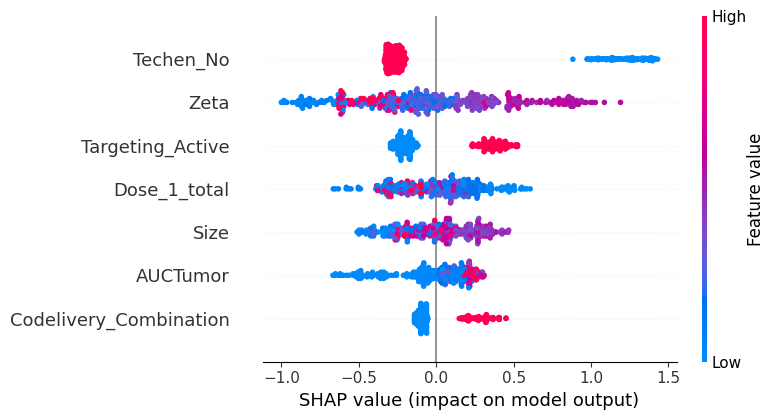

In [ ]:
shap.summary_plot(shap_values, X_scaled, max_display=7)

In [ ]:
import shap
import matplotlib.pyplot as plt

# Create a figure object and assign it explicitly
fig = plt.figure()
shap.summary_plot(shap_values, X_scaled, max_display=7, show=False)  # suppress immediate display

plt.tight_layout()
fig.savefig("shap_summary_plot.png", dpi=300, bbox_inches='tight')
plt.close()


In [ ]:
import numpy as np
import pandas as pd
import os

def export_all_shap_long(features, shap_values, X_data,
                         use_log=False, color_feature=None,
                         output_dir=".", combined_filename="shap_long_merged.csv"):

    # Build output path and remove existing file to ensure a clean export
    combined_path = os.path.join(output_dir, combined_filename)
    if os.path.exists(combined_path):
        os.remove(combined_path)
        print(f"Removed existing file → {combined_path}")

    all_rows = []  # to collect all exported feature rows

    #  Process each feature
    for feature_name in features:
        x_vals = X_data[feature_name].values
        shap_index = list(X_data.columns).index(feature_name)
        shap_vals = shap_values[:, shap_index]

        # Optional log transformation
        if use_log:
            mask = x_vals > 0  # log valid only for positive values
            x_vals = x_vals[mask]
            shap_vals = shap_vals[mask]
            sample_id = np.arange(len(X_data))[mask]
            color_vals = X_data[color_feature].values[mask] if color_feature else x_vals
        else:
            sample_id = np.arange(len(X_data))
            color_vals = X_data[color_feature].values if color_feature else x_vals

        # Create long-format dataframe
        df_export = pd.DataFrame({
            "Feature_Name": feature_name,
            "Sample_ID": sample_id,
            "Feature_Value": x_vals,
            "SHAP_Value": shap_vals,
            "Color_Value": color_vals
        })

        all_rows.append(df_export)

        print(f"Processed {feature_name}: appended {len(df_export)} rows")

    # Concatenate feature results
    final_df = pd.concat(all_rows, ignore_index=True)

    # Write to CSV
    final_df.to_csv(combined_path, index=False)

# Example list of features to export
features_to_export = ["Size", "Dose_1_total", "AUCTumor", "Zeta"]

# Run once to generate clean merged CSV
export_all_shap_long(
    features=features_to_export,
    shap_values=shap_values,
    X_data=preData
)


🧹 Removed existing file → ./shap_long_merged.csv
✓ Processed Size: appended 421 rows
✓ Processed Dose_1_total: appended 421 rows
✓ Processed AUCTumor: appended 421 rows
✓ Processed Zeta: appended 421 rows
